Notes on "Why Most Published Research Findings Are False" by John P. A. Ioannidis (2006)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sympy import symbols, Eq, solve, simplify, lambdify

$R$ is the ratio of true positive $t$ and negative $f$ findings:

$R = t / f$

$p$ is the probability of a positive:

$p = t / (t + f)$

$p$ in terms of $R$:

$$
1 / p = 1 + f / t =  1 + 1 / R
$$

$$
p = 1 / (1 + 1 / R)
$$

Mulitply top and bottom of RHS by R:

$$
p = R / (R + 1)
$$

In [4]:
p, R, t, f = symbols('p, R, t, f')

In [5]:
req =  Eq(R, t / f)
peq = Eq(p, t / (t + f))

In [6]:
solutions = solve((req, peq))
R_from_p =solutions[0][R]
R_from_p

-p/(p - 1)

In [7]:
p_from_R = solve(Eq(R, R_from_p), p)[0]
p_from_R

R/(R + 1)

In [8]:
assert simplify(p - 1 / (1 + 1 / R_from_p)) == 0

In [9]:
# Confirm R / (R + 1) == p
simplify(R_from_p / (R_from_p + 1))

p

The total at the top left of table 1 of Ioannidis

In [10]:
a, b = symbols('a, b')
Rp = R_from_p
expr = (R + a - b * R) / (R + 1)
ion_end = simplify(expr.subs(R, Rp))
ion_end

-a*(p - 1) - b*p + p

Which is the same as the bottom right equivalent in appendix table 1 of Wacholder et al 2004:

In [11]:
simplify(ion_end - ((1 - b) * p + a * (1 - p))) 

0

Values in table 2 of Ioannidis. Table 2 assumes that a proportion $u$ of the previously non-significant findings have become significant findings, due to bias:

In [12]:
u = symbols('u')

Top left value:

In [13]:
expr = ((1 - b) + u * b) * R / (R + 1)
ion2_first = simplify(expr.subs(R, Rp))
ion2_first

p*(b*u - b + 1)

Confirm equivalent expression in terms of $p$:

In [14]:
assert simplify(ion2_first - ((1 - b) * p + u * b * p)) == 0

Investigating the second table with respect to the first:

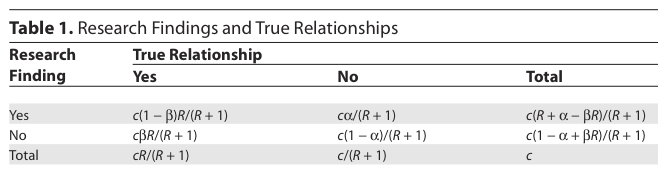

In [15]:
# Table 1 from Ioannides 2005
from IPython.core.display import Image
Image('pics/ioannidis_table1.png')

In [16]:
c = symbols('c')
table1_00 = c * (1 - b) * R / (R + 1)
table1_01 = c * a  / (R + 1)
table1_02 = c * (R + a - b * R) / (R + 1)
table1_10 = c * b * R / (R + 1)
table1_11 = c * (1 - a) / (R + 1)
table1_12 = c * (1 - a + b * R) / (R + 1)
# Check row totals
assert simplify(table1_02 - table1_00 - table1_01) == 0
assert simplify(table1_12 - table1_10 - table1_11) == 0
# Check column totals
assert simplify(c * R / (R + 1) - table1_00 - table1_10) == 0
assert simplify(c / (R + 1) - table1_01 - table1_11) == 0

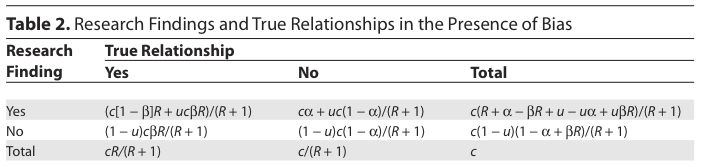

In [17]:
# Table 2 from Ioannides 2005
Image('pics/ioannidis_table2.png')

In [18]:
table2_00 = (c * (1 - b) * R + u * c * b * R) / (R + 1)
assert simplify(table2_00 - table1_00 - u * table1_10) == 0
# table2_01 has missing brackets.  Here's the version as written:
table2_01_bad = c * a + u * c * (1 - a) / (R + 1)
# Here's what it should be:
table2_01 = (c * a + u * c * (1 - a)) / (R + 1)
assert simplify(table2_01 - table1_01 - u * table1_11) == 0
table2_02 = c * (R + a - b * R + u - u * a + u * b * R) / (R + 1)
table2_10 = (1 - u) * c * b * R / (R + 1)
assert simplify(table2_10 - (1 - u) * table1_10) == 0
table2_11 = (1 - u) * c * (1 - a) / (R + 1)
assert simplify(table2_11 - (1 - u) * table1_11) == 0
table2_12 = c * (1 - u) * (1 - a + b * R) / (R + 1)
# Check row totals
assert simplify(table2_02 - table2_00 - table2_01) == 0
assert simplify(table2_12 - table2_10 - table2_11) == 0
# Check column totals
assert simplify(c * R / (R + 1) - table2_00 - table2_10) == 0
assert simplify(c / (R + 1) - table2_01 - table2_11) == 0

Expression for PPV:

In [19]:
ppv_nobias = table1_00 / (table1_00 + table1_01)

Check against text:

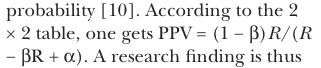

In [20]:
Image('pics/nobias_formula.png')

In [21]:
assert simplify(ppv_nobias - (1 - b) * R / (R - b * R + a)) == 0

Formula in the case of bias:

In [22]:
ppv_bias = table2_00 / (table2_00 + table2_01)

Check against formula in text:

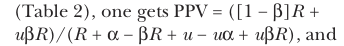

In [23]:
Image('pics/bias_formula.png')

In [24]:
ppv_bias_text =  ((1 - b) * R + u * b * R) / (R + a - b * R + u - u * a + u * b * R)
assert simplify(ppv_bias - ppv_bias_text) == 0

Let's see how that works out numerically:

In [25]:
ppv_bias_func = lambdify((R, a, b, c, u), ppv_bias)

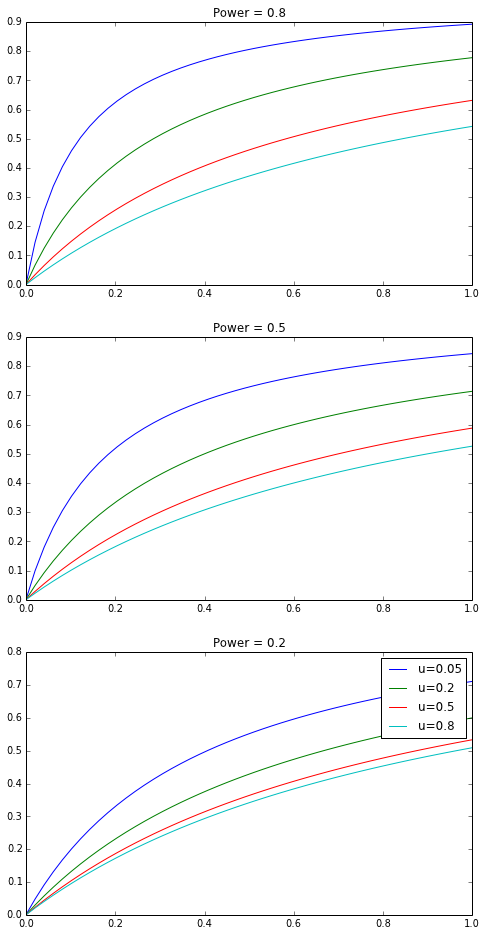

In [26]:
r_vals = np.linspace(0, 1)
fig, axes = plt.subplots(3, 1, figsize=(8, 16))
alpha = 0.05
for i, power in enumerate((0.8, 0.5, 0.2)):
    beta = 1 - power
    for bias in (0.05, 0.2, 0.5, 0.8):
        ppv = ppv_bias_func(r_vals, alpha, beta, 1, bias)
        axes[i].plot(r_vals, ppv, label='u={0}'.format(bias))
    axes[i].set_title('Power = {0}'.format(power))
axes[-1].legend()

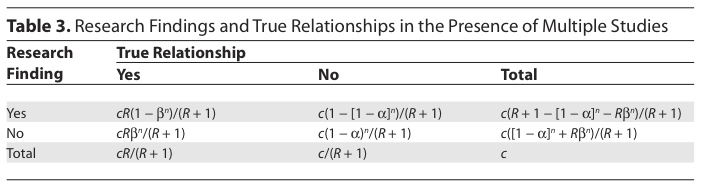

In [27]:
Image('pics/ioannidis_table3.png')

Multiple studies:

In [28]:
n = symbols('n')
# Chance in table (without knowing p / R)
ns_true = b ** n
s_true = 1 - ns_true
ns_false = (1 - a) ** n
s_false = 1 - ns_false
# With knowledge of p / R
rr1 = R / (R + 1) # also p
s_true_post = s_true * rr1
s_false_post = s_false * (1 - rr1)
ppv_multi = simplify(s_true_post / (s_true_post + s_false_post))
ppv_multi

R*(b**n - 1)/(R*(b**n - 1) + (-a + 1)**n - 1)

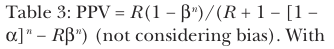

In [29]:
Image('pics/multi_formula.png')

In [30]:
assert simplify(ppv_multi - (R * (1 - b ** n) / (R + 1 - (1 - a) ** n - R * b ** n))) == 0

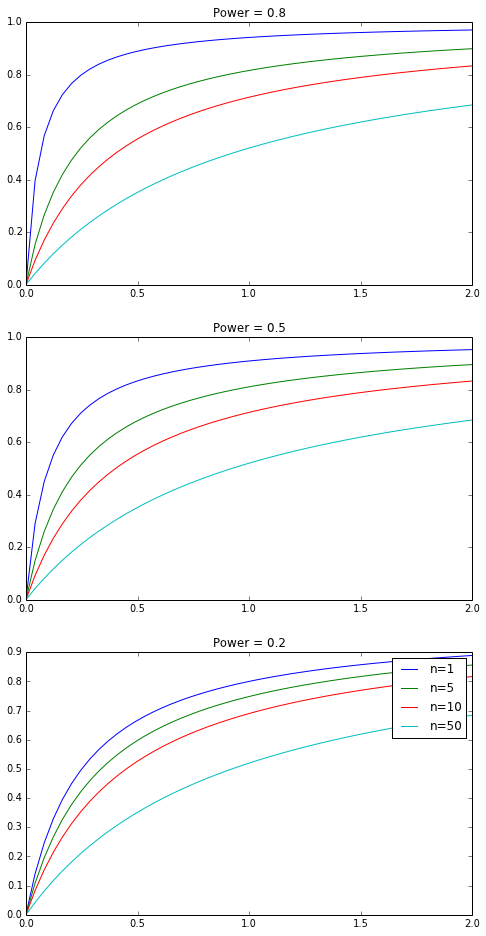

In [37]:
ppv_multi_func = lambdify((R, a, b, n), ppv_multi)
fig, axes = plt.subplots(3, 1, figsize=(8, 16))
alpha = 0.05
for i, power in enumerate((0.8, 0.5, 0.2)):
    beta = 1 - power
    for n_studies in (1, 5, 10, 50):
        ppv = ppv_multi_func(r_vals, alpha, beta, n_studies)
        axes[i].plot(r_vals, ppv, label='n={0}'.format(n_studies))
    axes[i].set_title('Power = {0}'.format(power))
axes[-1].legend()

But - is this formula correct?  The probability for any one study to be not-significant when $H_A$ is true is $\beta R / (R + 1)$.   Then, for multiple studies, surely:

In [38]:
ns_true_better = (b * rr1) ** n
s_true_better = rr1 - ns_true_better
ns_false_better = ((1 - a) * (1 - rr1)) ** n
s_false_better = (1 - rr1) - ns_false_better
ppv_multi_better = s_true_better / (s_true_better + s_false_better)
ppv_multi_better

(R/(R + 1) - (R*b/(R + 1))**n)/(-((-a + 1)*(-R/(R + 1) + 1))**n - (R*b/(R + 1))**n + 1)

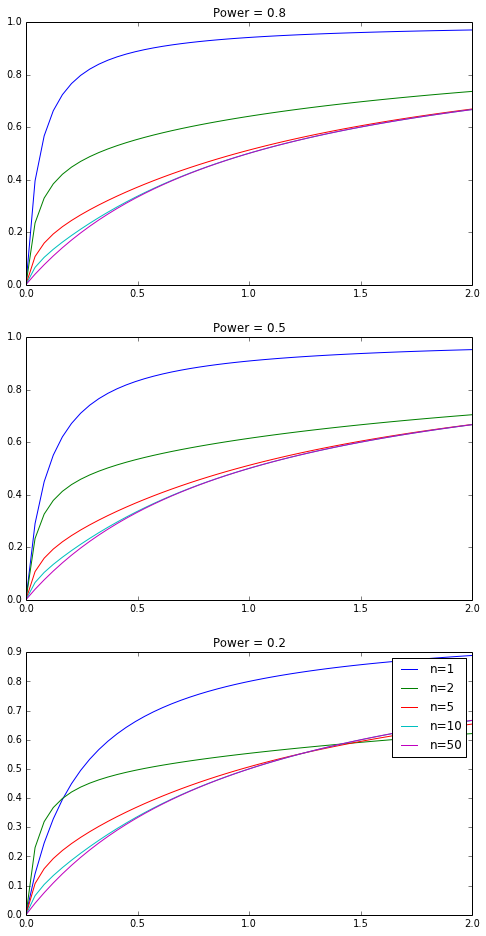

In [39]:
ppv_multi_better_func = lambdify((R, a, b, n), ppv_multi_better)
r_vals = np.linspace(0, 2)
fig, axes = plt.subplots(3, 1, figsize=(8, 16))
alpha = 0.05
for i, power in enumerate((0.8, 0.5, 0.2)):
    beta = 1 - power
    for n_studies in (1, 2, 5, 10, 50):
        ppv = ppv_multi_better_func(r_vals, alpha, beta, n_studies)
        axes[i].plot(r_vals, ppv, label='n={0}'.format(n_studies))
    axes[i].set_title('Power = {0}'.format(power))
axes[-1].legend()

Oops, that last one doesn't look right...

In [45]:
x = symbols('x')
solve(2 * x - x * x - 0.5, x)

[0.292893218813452, 1.70710678118655]

In [43]:
import sympy
area = sympy.integrate(2 - 2 * x)
solve(Eq(area, 0.5))

[0.292893218813452, 1.70710678118655]

In [44]:
area

-x**2 + 2*x

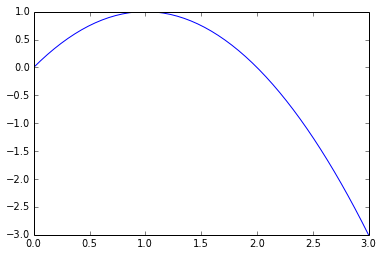

In [47]:
x_vals = np.linspace(0, 3)
plt.plot(x_vals, lambdify(x, area)(x_vals))

In [48]:
simplify(2 * x - x * x - 0.5)

-x**2 + 2*x - 0.5